In [29]:
import tensorflow as tf
import qutip as qt
import numpy as np
import os
import time

from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.environments import suite_mujoco
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.agents.reinforce import reinforce_agent
from absl import logging
from tqdm.auto import trange
from sorcery import dict_of

%load_ext autoreload
%autoreload 
from Noises import Noise
from QTransferEnv import *
from Plots import *
from SaveLoad import save_params, load_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [31]:
newRun = True
load_hyperparams = None
save_hyperparams = True
save_best_pulses = True
timestamp = time.strftime("%Y%m%d-%H%M%S")

In [32]:
N = 3
Ωmax = 20
n_steps = 50
c_ops = []
t_max = 2
initial_state = qt.basis(N, 0)
target_state = qt.basis(N, N-1)
noise = Noise("gaussian", percentage=0.05)
deltas = np.zeros(N, dtype=complex)
deltas[1] = 0 - 1j

num_iterations = 100
reward_gain = 1.0
summaries_flush_secs = 1
num_eval_episodes = 10

fc_layer_params=(100, 50, 30)
optimizer_learning_rate=1e-3
replay_buffer_episodes_capacity=20
initial_collect_episodes=10
collect_episodes_per_iteration=1
use_tf_functions=True
batch_size=256
train_steps_per_iteration=1

eval_interval=10
summary_interval=10

train_checkpoint_interval=-1
policy_checkpoint_interval=-1
rb_checkpoint_interval=-1
log_interval=-1

replay_buffer_capacity=replay_buffer_episodes_capacity * n_steps

root_dir = 'logs/'
root_dir = os.path.expanduser(root_dir)
if newRun:
    train_dir = os.path.join(root_dir, 'train' + timestamp)
    eval_dir = os.path.join(root_dir, 'eval' + timestamp)
else:
    train_dir = os.path.join(root_dir, 'train', 'run-1')
    eval_dir = os.path.join(root_dir, 'eval', 'run-1')

In [33]:
env_train_py = QTransferEnv(N=N,
                            t_max=t_max,
                            n_steps=n_steps,
                            initial_state=initial_state,
                            target_state=target_state,
                            reward_gain=reward_gain,
                            c_ops=c_ops,
                            omega_min=0,
                            omega_max=Ωmax,
                            noise=noise,
                            deltas=deltas)

env_eval_py = QTransferEnv(N=N,
                           t_max=t_max,
                           n_steps=n_steps,
                           initial_state=initial_state,
                           target_state=target_state,
                           reward_gain=reward_gain,
                           c_ops=c_ops,
                           omega_min=0,
                           omega_max=Ωmax,
                           noise=noise,
                           deltas=deltas)

In [34]:
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    train_dir, flush_millis=summaries_flush_secs * 1000)
train_summary_writer.set_as_default()

eval_summary_writer = tf.compat.v2.summary.create_file_writer(
    eval_dir, flush_millis=summaries_flush_secs * 1000)

In [35]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [8]:
with tf.compat.v2.summary.record_if(lambda: tf.math.equal(global_step % summary_interval, 0)):
    tf_env = tf_py_environment.TFPyEnvironment(env_train_py)
    eval_tf_env = tf_py_environment.TFPyEnvironment(env_eval_py)

    time_step_spec = tf_env.time_step_spec()
    observation_spec = time_step_spec.observation
    action_spec = tf_env.action_spec()

    # Actor Network
    actor_net = actor_distribution_network.ActorDistributionNetwork(
        observation_spec,
        action_spec,
        fc_layer_params=fc_layer_params,
    )

    # Agent
    tf_agent = reinforce_agent.ReinforceAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=optimizer_learning_rate),
        normalize_returns=True,
        train_step_counter=global_step,
    )

    tf_agent.initialize()

    # Replay Buffers
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=tf_env.batch_size,
        max_length=replay_buffer_capacity,
    )
    replay_observer = [replay_buffer.add_batch]

    eval_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=eval_tf_env.batch_size,
        max_length=n_steps + 1,
    )
    eval_replay_observer = [eval_replay_buffer.add_batch]

    # Train Metrics
    train_metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.EnvironmentSteps(),
        tf_metrics.AverageReturnMetric(
            buffer_size=num_eval_episodes, batch_size=tf_env.batch_size),
        tf_metrics.AverageEpisodeLengthMetric(
            buffer_size=num_eval_episodes, batch_size=tf_env.batch_size),
    ]

    # Eval Metrics
    eval_metrics = [
        tf_metrics.AverageReturnMetric(buffer_size=num_eval_episodes),
        tf_metrics.AverageEpisodeLengthMetric(buffer_size=num_eval_episodes)
    ]

    # Policies
    eval_policy = tf_agent.policy
    initial_collect_policy = random_tf_policy.RandomTFPolicy(time_step_spec, action_spec)
    collect_policy = tf_agent.collect_policy

    # Checkpoints
    train_checkpointer = common.Checkpointer(
        ckpt_dir=train_dir,
        agent=tf_agent,
        global_step=global_step,
        metrics=metric_utils.MetricsGroup(train_metrics, 'train_metrics'))
    policy_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(train_dir, 'policy'),
        policy=eval_policy,
        global_step=global_step)
    rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)

    train_checkpointer.initialize_or_restore()
    rb_checkpointer.initialize_or_restore()

    # Drivers
    initial_collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(
        tf_env,
        initial_collect_policy,
        observers=replay_observer + train_metrics,
        num_episodes=initial_collect_episodes)

    collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(
        tf_env,
        collect_policy,
        observers=replay_observer + train_metrics,
        num_episodes=collect_episodes_per_iteration)

    eval_driver = dynamic_episode_driver.DynamicEpisodeDriver(
        eval_tf_env,
        eval_policy,
        eval_replay_observer + eval_metrics,
        num_episodes=1)

    if use_tf_functions:
        initial_collect_driver.run = common.function(initial_collect_driver.run)
        collect_driver.run = common.function(collect_driver.run)
        eval_driver.run = common.function(eval_driver.run)
        tf_agent.train = common.function(tf_agent.train)

    if replay_buffer.num_frames() == 0:
        # Collect initial replay data.
        initial_collect_driver.run()

    # Save initial eval metrics
    eval_driver.run()
    metric_utils.log_metrics(eval_metrics)

    time_step = None
    policy_state = collect_policy.get_initial_state(tf_env.batch_size)

    timed_at_step = global_step.numpy()
    time_acc = 0

    def train_step():
        experience = replay_buffer.gather_all()
        return tf_agent.train(experience)

    if use_tf_functions:
        train_step = common.function(train_step)

    global_step_val = global_step.numpy()
    
    best_population = -1
    best_episode = None
    # Training Loop
    with trange(num_iterations, dynamic_ncols=False) as t:
        for global_step_val in t: # while global_step_val < num_iterations:
            t.set_description(f'Episode {global_step_val}')

            start_time = time.time()
            time_step, policy_state = collect_driver.run(
                time_step=time_step,
                policy_state=policy_state,
            )

            for _ in range(train_steps_per_iteration):
                train_loss = train_step()
            time_acc += time.time() - start_time

            global_step_val = global_step.numpy()

            # Logging each log_interval
            if global_step_val % log_interval == 0:
                logging.info('step = %d, loss = %f', global_step_val,
                            train_loss.loss)
                steps_per_sec = (global_step_val - timed_at_step) / time_acc
                logging.info('%.3f steps/sec', steps_per_sec)
                tf.compat.v2.summary.scalar(
                    name='global_steps_per_sec', data=steps_per_sec, step=global_step)
                timed_at_step = global_step_val
                time_acc = 0
            
            for train_metric in train_metrics:
                train_metric.tf_summaries(
                    train_step=global_step, step_metrics=train_metrics[:2])

            # Evaluate each eval_interval
            if global_step_val % eval_interval == 0:
                eval_metrics[0].reset()
                eval_driver.run()
                if best_population < eval_metrics[0].result().numpy():
                    best_population = eval_metrics[0].result().numpy()
                    best_episode = eval_replay_buffer.gather_all()
                metric_utils.log_metrics(eval_metrics)
                with eval_summary_writer.as_default():
                    tf.compat.v2.summary.scalar(
                        name='best_population', data=best_population, step=global_step)

                t.set_postfix({"Avg eval return": best_population})

            # Train checkpoint save each train_checkpoint_interval
            if global_step_val % train_checkpoint_interval == 0:
                train_checkpointer.save(global_step=global_step_val)

            # Policy checkpoint save each policy_checkpoint_interval
            if global_step_val % policy_checkpoint_interval == 0:
                    policy_checkpointer.save(global_step=global_step_val)

            # Replay Buffer save each rb_checkpoint_interval
            if global_step_val % rb_checkpoint_interval == 0:
                rb_checkpointer.save(global_step=global_step_val)

2023-04-18 13:12:47.492067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0' with dtype int32 and shape [1]
	 [[{{node arg_0}}]]
2023-04-18 13:12:47.492147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0_3' with dtype int32 and shape [1]
	 [[{{node arg_0_3}}]]
2023-04-18 13:12:47.499617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'driver_loop/Placeholder_1' with dtype int32 and shape [1]
	 [[{{node driver_loop/Placehol

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
2023-04-18 13:12:48.963481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0' with dtype int32 and shape [1]
	 [[{{node arg_0}}]]
2023-04-18 13:12:48.963570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0_3' with dtype int32 and shape [1]
	 [[{{node arg_0_3}}]]
2023-04-18 13:12:48.970293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

  0%|          | 0/100 [00:00<?, ?it/s]

2023-04-18 13:12:49.421541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'driver_loop/Placeholder_1' with dtype int32 and shape [1]
	 [[{{node driver_loop/Placeholder_1}}]]


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
2023-04-18 13:12:51.114498: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:530] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2023-04-18 13:12:51.228554: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-18 13:12:51.230682: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-18 13:12:51.230799: W tenso

Population 3: 0.4751119017601013
Total population: 0.5592047572135925


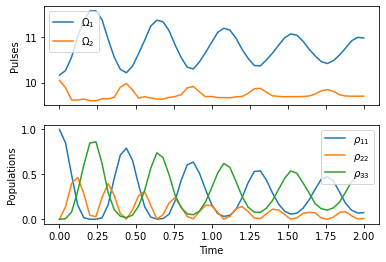

In [9]:
times = env_eval_py.times
plot_episode(times, best_episode)
print("Population {}: {}".format(N, best_episode.observation.numpy()[0, -1, N - 1]))
print("Total population: {}".format(np.sum(best_episode.observation.numpy()[0, -1, :N])))

In [13]:
if save_best_pulses:
    np.save(os.path.join(eval_dir, "best_pulses_" + timestamp + ".npy"), best_episode.action.numpy()[0, :, :].T)

In [23]:
if save_hyperparams:
    params = dict_of(N,
                     num_iterations,
                     fc_layer_params,
                     replay_buffer_episodes_capacity,
                     Ωmax,
                     n_steps,
                     t_max,
                     deltas,
                     initial_state,
                     target_state,
                     c_ops,
                     noise,
                     initial_collect_episodes,
                     optimizer_learning_rate,
                     eval_interval,
                     summary_interval,
                     train_checkpoint_interval,
                     policy_checkpoint_interval,
                     rb_checkpoint_interval,
                     log_interval,
                     reward_gain,
                     summaries_flush_secs,
                     num_eval_episodes,
                     collect_episodes_per_iteration,
                     use_tf_functions,
                     batch_size,
                     train_steps_per_iteration,
                     root_dir,
                     train_dir,
                     eval_dir,
                     timestamp,
                     )
    save_params(os.path.join(eval_dir, "hyperparams_" + timestamp), params, show=True, add_time=False)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/eval20230418-131242/params_20230418-132124.pkl'